In [1]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.AtomPairs import Torsions
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import LayeredFingerprint
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import pickle
import matplotlib
import warnings
import time
import os

warnings.filterwarnings("ignore")

    
def R2(y_pred, y_true):       
    """This function is used to calculate the R2 score.
    Arg:
        y_pred(array): Data to be processed.
        y_true(array): Scaler's method(include standard, minmax).
    Return:
        array: R2 score.
    """
    return 1- mean_squared_error(y_true,y_pred)/ np.var(y_true)
    
def scale(data, method):
    """This function is used to scale the data.
    Arg:
        data(array): Data to be processed.
        method(str): Scaler's method(include standard, minmax).
    Return:
        array: Processed data.
    """

    sca_data = []

    if method == 'standard':
        scaler = StandardScaler()
        sca_data.append(scaler.fit_transform(data))

    if method == 'minmax':
        scaler = MinMaxScaler()
        sca_data.append(scaler.fit_transform(data))

    return sca_data

def get_fp(X, fingerprint_type):
    """This function is used to get the fingerprint data.
    Arg:
        X(array): Data to be processed.
        fingerprint_type(str): Type of fingerprint ('morgan', 'rdkit', 'avalon', 'layer', or 'mol2vec').
    Return:
        array: Fingerprint data.
    """
    index = None
    fp_record = []
    mv_record = []
    if fingerprint_type == 'mol2vec':
        index = 300
        model = word2vec.Word2Vec.load('model_300dim.pkl')
        X['sentence_olefin'] = X.apply(lambda x: MolSentence(mol2alt_sentence(Chem.MolFromSmiles(x[0]), 1)), axis=1)
        X['sentence_ligand'] = X.apply(lambda x: MolSentence(mol2alt_sentence(Chem.MolFromSmiles(x[2]), 1)), axis=1)
        X['mol2vec_olefin'] = [DfVec(x) for x in sentences2vec(X['sentence_olefin'], model, unseen='UNK')]
        X['mol2vec_ligand'] = [DfVec(x) for x in sentences2vec(X['sentence_ligand'], model, unseen='UNK')]
        fp_record.append(np.array([x.vec for x in X['mol2vec_olefin']]))
        fp_record.append(np.array([x.vec for x in X['mol2vec_ligand']]))
        
    else:    
        for i in range(len(X.iloc[:,1])):
            for j in [0, 2]:
                mol = Chem.MolFromSmiles(X.iloc[i,j])
                if mol is not None:
                    # Obtain different types of fingerprints
                    if fingerprint_type == 'morgan':
                        index = 1024
                        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
                    elif fingerprint_type == 'rdkit':
                        index = 2048  
                        fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol)
                    elif fingerprint_type == 'avalon':
                        index = 1024
                        fp = pyAvalonTools.GetAvalonFP(mol, nBits=1024)
                    elif fingerprint_type == 'layer':
                        index = 2048  
                        fp = LayeredFingerprint(mol)
                    elif fingerprint_type == 'torsion':
                        index = 2048
                        fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
                    else:
                        raise ValueError("Invalid fingerprint type")
                    
                    #Convert to list and add to record list
                    b = np.zeros((1,))
                    ConvertToNumpyArray(fp, b)
                    fp_record.append(b)
        
    #Convert the record list into an array and divide it into two parts by index
    input1 = np.array(fp_record).reshape(-1, index*2)
    input_pca1 = StandardScaler().fit_transform(input1[:, :index])
    input_pca2 = StandardScaler().fit_transform(input1[:, index:2*index])      
    
    return input_pca1, input_pca2

def prepare_data_and_cross_validation(df):

    test_index = [1, 2, 5, 7, 10, 12, 15, 18, 19, 33, 38, 45, 47, 52, 54, 55, 57, 58, 64, 65, 69, 72, 84, 103, 104, 105, 110, 113, 119,
                  127, 131, 134, 136, 140, 150, 156, 159, 168, 178, 185, 187, 190, 191, 192, 195, 197, 198, 202, 203, 205, 207, 214,
                  218, 222, 227, 232, 236, 237, 240, 248, 253, 259, 270, 284, 285, 287, 303, 306, 311, 313, 317, 319, 339, 344, 351,
                  352, 355, 371, 375, 379, 380, 387, 390, 393, 408, 415, 416, 420, 421, 429, 430, 432, 438, 439, 441, 442, 446, 453,
                  454, 469, 472, 474, 482, 486, 489, 490, 493, 494, 497, 499, 504, 518, 522, 523, 525, 539, 551, 556, 557, 561, 578,
                  584, 591, 593, 598, 600, 614, 620, 621, 626, 632, 633, 634, 643, 650, 653, 660, 661, 665, 671, 673, 686, 693, 702,
                  703, 709, 710, 711, 716, 723, 733, 735, 736, 737, 743, 747, 760, 764, 767, 772, 779, 783, 785, 799, 800, 801, 809,
                  810, 812, 813, 815, 820, 821, 824, 828, 833, 837, 838, 840, 855, 859, 861, 862, 864, 874, 889, 896, 916, 924, 925,
                  927, 932, 936, 938, 942, 944, 946, 955, 958, 960, 982, 986, 987, 991, 996, 997, 1002, 1005, 1009, 1012, 1014, 1017,
                  1033, 1034, 1057, 1071, 1072, 1076, 1079, 1080, 1082, 1095, 1100, 1102, 1104, 1107, 1108, 1110, 1120, 1122, 1133,
                  1136, 1138, 1145, 1157, 1159, 1164]

    # 构建测试集和训练集
    df_test = df.loc[test_index]
    df_train = df.drop(test_index)

    # 五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 合并类别标签，用于StratifiedKFold
    y = df_train['solvent'].astype(str) + "_" + df_train['olefin'].astype(str) + "_" + df_train['metal'].astype(str)

    cv_fold = []

    for train_index, val_index in skf.split(df_train, y):
        cv_fold.append((train_index, val_index))

    return test_index, cv_fold

def input_generate(df, des, bool, seed=0, global_type=None, local_type=None, reduction_method='PCA', reduct_dim=4):
    """This function is used to generate the input data for the model.
    Args:
        df (pd.Dataframe): Dataframe of the dataset.
        des (pd.Dataframe): Dataframe of the descriptor.
        bool (np.array): Boolean index.
        seed(int, optional): Splitting method. Defaults to 0.
        global_type (str, optional): Global type of the data. Defaults to None. Options: morgan, mbtr, rdkit, avalon, layer, mol2vec, torsion.
        local_type (str, optional): Local type of the data. Defaults to None. Options: acsf, lmbtr, soap.
        reduction_method (str, optional): Reduction methods. Options: 'PCA', 'KernelPCA', None.
        reduct_dim (int, optional): Reducted dimension of the data. Defaults to 4.
    Returns:
        array: Train data for the model.
        array: Target of train data for the model.
        array: Test data for the model.
        array: Target of test data for the model.
    """
    def load_csv(file_name):
        return pd.read_csv(f'./{file_name}.csv', index_col=0)

    olefin_local = load_csv(f'{local_type}-ff-olefin')[bool] if local_type else None
    ligand_local = load_csv(f'{local_type}-ff-Ligand-M')[bool] if local_type else None
    olefin_global = load_csv(f'{global_type}-ff-olefin')[bool] if global_type == 'mbtr' else None
    ligand_global = load_csv(f'{global_type}-ff-Ligand-M')[bool] if global_type == 'mbtr' else None

    if global_type and global_type != 'mbtr':
        olefin_global, ligand_global = get_fp(df, fingerprint_type=global_type)

    des = des[bool] 
    df = df[bool] 
    y = des.iloc[:, -1].values
    input2 = des.iloc[:, :-1]

    test_index, cv_fold = prepare_data_and_cross_validation(df)
    train_index = list(set(range(len(des))) - set(test_index))
    
    def standardize_and_reduce(train_data, test_data, method, dim):
        scaler = StandardScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)
        
        if method == 'PCA':
            reducer = PCA(n_components=dim, random_state=2024)
        elif method == 'KernelPCA':
            reducer = KernelPCA(n_components=dim, kernel='rbf', random_state=2024)
        else:
            return train_data, test_data
        
        train_data = reducer.fit_transform(train_data)
        test_data = reducer.transform(test_data)
        return train_data, test_data

    def split_and_standardize(data, input2=False):
        if data is not None:
            if isinstance(data, pd.DataFrame):
                train_data = data.iloc[train_index].values
                test_data = data.iloc[test_index].values
            else:
                train_data = data[train_index]
                test_data = data[test_index]
            
            if input2:
                scaler2 = StandardScaler()
                train_data = scaler2.fit_transform(train_data)
                test_data = scaler2.transform(test_data)
                return train_data, test_data
            else:
                return standardize_and_reduce(train_data, test_data, reduction_method, reduct_dim)
        return None, None

    def remove_highly_correlated_features(train_data, test_data, threshold=0.7):
        corr_matrix = np.corrcoef(train_data, rowvar=False)
        upper_triangle_indices = np.triu_indices_from(corr_matrix, k=1)
        to_remove = set()
        removed_columns = [] # A list used to record deleted columns
        for i, j in zip(*upper_triangle_indices):
            if abs(corr_matrix[i, j]) > threshold:
                to_remove.add(j)
                removed_columns.append(j)# Add the deleted column index to the list
        train_data = np.delete(train_data, list(to_remove), axis=1)
        test_data = np.delete(test_data, list(to_remove), axis=1)
        return train_data, test_data
    
    # Split and standardize data
    olefin_local_train, olefin_local_test = split_and_standardize(olefin_local)
    ligand_local_train, ligand_local_test = split_and_standardize(ligand_local)
    olefin_global_train, olefin_global_test = split_and_standardize(olefin_global)
    ligand_global_train, ligand_global_test = split_and_standardize(ligand_global)
    input2_train, input2_test = split_and_standardize(input2, input2=True)
    train_input_list = [arr for arr in [olefin_global_train, ligand_global_train, olefin_local_train, ligand_local_train, input2_train] if arr is not None]
    test_input_list = [arr for arr in [olefin_global_test, ligand_global_test, olefin_local_test, ligand_local_test, input2_test] if arr is not None]

    combined_train_data = np.hstack(train_input_list)
    combined_test_data = np.hstack(test_input_list)   
    
    # Apply the correlation filtering on the combined data
    combined_train_data, combined_test_data = remove_highly_correlated_features(combined_train_data, combined_test_data)

    X_train = combined_train_data
    X_test = combined_test_data
    y_train = y[train_index]
    y_test = y[test_index]
    return X_train, X_test, y_train, y_test, cv_fold

def get_model_and_param_grid(method):
    if method == 'et':
        model = ExtraTreesRegressor(random_state=0)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 7, 9],
            'min_samples_split': [1, 2, 3]
        }
    elif method == 'nn':
        model = MLPRegressor(max_iter=200)
        param_grid = {
            'hidden_layer_sizes': [(256, 128, 64), (128, 64, 32)],
            'solver': ['adam'],
            'activation': ['relu'],
            'alpha': [0.1, 0.3, 0.5, 0.7]
        }
    elif method == 'xgboost':
        model = xgb.XGBRegressor(random_state=0, predictor='cpu_predictor')
        param_grid = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200],
            'reg_lambda':[0.3, 0.5]
        }
    elif method == 'dtr':
        model = DecisionTreeRegressor(random_state=0)
        param_grid = {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [1, 3, 5],
        }
    elif method == 'lgbm':
        param = {
                    'device': 'gpu',
                    'gpu_platform_id': 0,
                    'gpu_device_id': 0
                }
        model = lgb.LGBMRegressor(verbosity=-1, random_state=0, num_leaves=5,learning_rate=0.1, **param)
        param_grid = {
            'max_depth': [3, 4, 5],
            'n_estimators': [100, 200],
            'reg_lambda': [0.1, 0.4, 0.7],
            'num_iterations':[100, 200]
        }
    elif method == 'gpr':
        model = GaussianProcessRegressor(random_state=0)
        param_grid = {
            'kernel': [
                RBF(),
                Matern(nu=1.5),
                Matern(nu=2.5),
                RationalQuadratic()
            ]
        }
    elif method == 'krr':
        model = KernelRidge()
        param_grid = {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': [1e-7, 1e-5, 1e-3]
        }
    elif method == 'knn':
        model = KNeighborsRegressor()
        param_grid = {
                'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    elif method == 'cbr':
        model = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', verbose=False)
        param_grid = {
            'iterations': [200],
            'learning_rate': [0.1],
            'depth': [3, 5],
            'l2_leaf_reg': [1, 10, 100],
            'random_seed': [0]
        }
    else:
        raise ValueError(f"Method {method} is not supported.")
        
    return model, param_grid

def train_and_test(df, des, methods, seed, bool, global_types=None, local_types=None, reduction_method='PCA'
                   , reduct_dim=4, score='neg_mean_squared_error'):
    best_global_type = None
    best_local_type = None
    best_results = None
    best_method = None
    best_mean_score = 0 # for mse,mae:float('inf')
    best_y_pred = None
    best_y_true = None
    combination = []
    mean_cv_score_record = []
    
    for global_type in global_types:
        for local_type in local_types:
            X_train, X_test, y_train, y_test, cv_fold = input_generate(df, des, bool, seed, global_type, local_type, reduction_method, reduct_dim)
            for method in methods:
                model, param_grid = get_model_and_param_grid(method)
                scores = []
                record_models = []
                record_params = []
                y_test_record = []
                y_pred_record = []
                
                search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=cv_fold, n_jobs=3, verbose=1)
                # Using cross validation to discover the best model for adapting to the training set
                search.fit(X_train, y_train)
                individual_model = search.best_estimator_
                record_models.append(individual_model)
                record_params.append(search.best_params_)
                # Obtain cross validation results
                scores.append(search.best_score_)
                
                # Calculate the average cross validation error
                mean_cv_score = np.mean(scores)
                combination.append(f'{global_type}-{local_type}-{method}')
                mean_cv_score_record.append(mean_cv_score)

                # 更新最佳结果
                if mean_cv_score > best_mean_score:
                    best_mean_score = mean_cv_score
                    best_model = individual_model
                    best_results = {
                        'best_models': record_models,
                        'best_params': record_params,
                        'nested_cv_score': np.abs(scores)
                    }
                    best_global_type = global_type
                    best_local_type = local_type
                    best_method = method
                    best_X_test = X_test
                    best_y_test = y_test

                
    print(f'best result: {best_global_type}-{best_local_type}-{best_method}-{best_mean_score}')  
    
    data = {'combination': combination, 'mse': np.abs(mean_cv_score_record)}
    df = pd.DataFrame(data)

    # Function to delete a file if it exists
    def delete_if_exists(file_path):
        if os.path.exists(file_path):
            os.remove(file_path)
    
    # Directory where the files will be saved
    model_path = './best_model'
    os.makedirs(model_path, exist_ok=True)
    
    # File paths
    best_model_file = os.path.join(model_path, 'best_model.pkl')
    X_test_file = os.path.join(model_path, 'X_test.pkl')
    y_test_file = os.path.join(model_path, 'y_test.pkl')
    
    # Delete files if they exist
    delete_if_exists(best_model_file)
    delete_if_exists(X_test_file)
    delete_if_exists(y_test_file)
    
    # Save the best model, X_test, and y_test
    with open(best_model_file, 'wb') as f:
        pickle.dump(best_model, f)
    with open(X_test_file, 'wb') as f:
        pickle.dump(best_X_test, f)
    with open(y_test_file, 'wb') as f:
        pickle.dump(best_y_test, f)
    
    print("Best model and test data saved successfully.")
    
    return best_global_type, best_local_type, best_method, best_results, df

In [2]:
# Hyperparameters
root_dir = './'

# Record the time
start = time.perf_counter()

# Load data
df = pd.read_csv(os.path.join(root_dir, './hydroformylation.csv'), index_col=0) # strip label's limitation
des = pd.read_csv(os.path.join(root_dir, 'descriptor.csv'), index_col=0) # FF=2
bool = df['olefin'] != '1'

# Record the time
start = time.perf_counter()

# Train and test
best_global_type, best_local_type, best_method, best_results, df2 = train_and_test(
                                                  df, des, methods=['et', 'xgboost', 'dtr', 'lgbm', 'gpr','krr', 'knn', 'cbr']
                                                  , seed=0, bool=bool
                                                  , global_types=['morgan','mbtr', 'avalon', 'layer', 'mol2vec', 'torsion', None]
                                                  , local_types=['acsf', 'lmbtr', 'soap', None]
                                                  , reduction_method='PCA', reduct_dim=8
                                                  , score='r2'
                                                  )

end = time.perf_counter()
print(f"model training consumed: {np.round(end - start, decimals=3)} sec.")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


  File "H:\anaconda\envs\tf\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "H:\anaconda\envs\tf\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "H:\anaconda\envs\tf\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "H:\anaconda\envs\tf\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds fo

Mean Squared Error: 0.10493872839413823, Mean Absolute Error: 0.2144405731129743


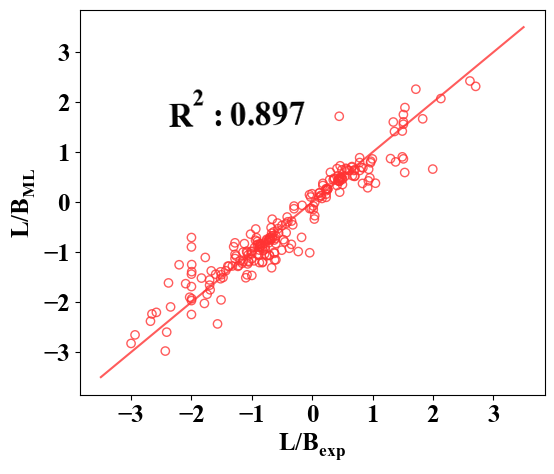

In [3]:
import pickle
import os

def load_best_model_and_data(model_path='./best_model'):
    # Load the best model
    with open(os.path.join(model_path, 'best_model.pkl'), 'rb') as f:
        best_model = pickle.load(f)
    
    # Load X_test
    with open(os.path.join(model_path, 'X_test.pkl'), 'rb') as f:
        X_test = pickle.load(f)
    
    # Load y_test
    with open(os.path.join(model_path, 'y_test.pkl'), 'rb') as f:
        y_test = pickle.load(f)

    return best_model, X_test, y_test

# Example usage
best_model, X_test, y_test = load_best_model_and_data()

# You can now use the loaded model and test data, for example:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}')

plt.rcParams['font.family'] = ["Times New Roman"]
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.default'] = 'regular'
plt.rc('font', family='times new roman')
fig, ax = plt.subplots(1, figsize=(6, 5))
plt.scatter(y_test, y_pred, label='Original Data', alpha=0.8, marker='o', facecolors='none', edgecolors=(1, 0.2, 0.2)) #0.2, 0.6, 0.2 0.2, 0.2, 0.8|1, 0.2, 0.2
plt.plot([-3.5,3.5], [-3.5, 3.5], c=(1, 0.2, 0.2),alpha=0.8, linewidth='1.5', label='Best Line')
plt.text(x=-2.4,
         y=1.5, 
         s=f'$R^2: {R2(y_test, y_pred):.3f}$', 
         rotation=1,
         fontsize=24,
         ha='left',
         va='baseline',
         fontweight='bold'
         )
plt.xlabel(r'$L / B _{exp}$', fontsize=18
           ,fontweight='bold'
          )  
plt.ylabel(r'$L / B _{ML}$', fontsize=18
           ,fontweight='bold'
          )
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(fontsize=18,fontweight='bold')
plt.show()